# Modul 7 Persamaan Diferensial Numerik: *Nonlinear Finite Difference*, PDP Eliptik & Hiperbolik

Kembali ke [Persamaan Diferensial Numerik](./pdnum2024genap.qmd)

(work in progress!)

Melanjutkan dari modul sebelumnya, untuk masalah nilai batas PDB, kita akan membahas metode

- *Nonlinear Finite Difference*

Kemudian, kita akan membahas metode numerik untuk menyelesaikan PDP (persamaan diferensial parsial) orde 2

- yang eliptik (persamaan Laplace / persamaan Poisson); dan

- yang hiperbolik (persamaan gelombang).

## *Nonlinear Finite Difference*

Metode ini digunakan untuk mengaproksimasi masalah nilai batas:

$$
\begin{gathered}
y^{\prime \prime}=f\left(x, y, y^{\prime}\right), \quad a \leq x \leq b \\
y(a)=\alpha, \quad y(b)=\beta
\end{gathered}
$$

dengan $f$ boleh berupa fungsi linier maupun nonlinier.

Metode ini bersifat iteratif, memanfaatkan yang namanya "metode Newton untuk sistem" yang dibahas di subbab 10.2 buku Burden, yang dibahas di mata kuliah Matematika Numerik. Daripada membahas secara umum mengenai metode Newton untuk sistem, kita cukup membahas bagaimana langkah-langkah metodenya khusus dalam penerapannya sebagai metode *nonlinear finite difference* untuk menyelesaikan masalah nilai batas.

Langkah-langkah metode *nonlinear finite difference* bisa ditulis sebagai berikut:

1.  Hitung rumus $f_y(x,y,y')$ (yaitu $\frac{\partial f}{\partial y}(x,y,y')$) dan rumus $f_{y'}(x,y,y')$ (yaitu $\frac{\partial f}{\partial y'}(x,y,y')$) secara analitik.

2. Tentukan toleransi $\varepsilon$, dan/atau maksimum banyaknya iterasi $M$.

3. Pastikan nilai $N$ dan *step size* $h$ sudah dimiliki. Biasanya hanya salah satu nilai yang diberikan (biasanya $N$). Hubungan antara keduanya adalah

    $$h = \frac{b-a}{N+1}$$

4. Ingat bahwa $w_0 = \alpha$ dan $w_{N+1} = \beta$. Kita perlu menentukan nilai-nilai $w_1, \dots, w_N$. Untuk nilai-nilai tersebut, pasang tebakan awal, berupa nilai-nilai di antara $\alpha$ dan $\beta$, sebagai berikut untuk $i = 1, \dots, N$:

    $$w_i = \alpha + i\left(\frac{\beta - \alpha}{b-a}\right)h$$

5. Susun suatu matriks tridiagonal berukuran $N \times N$ yang dinamakan matriks Jacobian, dengan entri
    $$J_{ij} = \begin{cases}
        -\left(1 + \frac{h}{2} f_{y'} \left(x_i, w_i, \frac{w_{i+1} - w_{i-1}}{2h}\right)\right) & \text{di bawah/kiri diagonal, baris ke-$i$} \\
        2 + h^2 f_{y} \left(x_i, w_i, \frac{w_{i+1} - w_{i-1}}{2h}\right) & \text{di diagonal, baris ke-$i$} \\
        -\left(1 - \frac{h}{2} f_{y'} \left(x_i, w_i, \frac{w_{i+1} - w_{i-1}}{2h}\right) \right) & \text{di atas/kanan diagonal, barsi ke-$i$} \\
        0 & \text{untuk semua elemen lainnya}
    \end{cases}$$

6. Susun vektor kolom bernama $d$ dengan $N$ baris, yang isinya sebagai berikut untuk $i = 1, \dots, N$:
    $$d_i = -w_{i-1} + 2w_i - w_{i+1} + h^2 f\left(x_i, w_i, \frac{w_{i+1}-w_{i-1}}{2h}\right)$$

7. Selesaikan SPL $Jv = -d$ (iya pakai minus), di mana vektor $v$ berisi nilai-nilai $v_1,\dots,v_N$ yang ingin diperoleh. Metode penyelesaian SPLnya terserah.

8. Perbarui vektor $w$ dengan menambahkan vektor $v$. Yaitu, nilai $w_1$ ditambahkan $v_1$, nilai $w_2$ ditambahkan $v_2$, dan seterusnya.

9. Sampai sini, selesai satu iterasi. Periksa apakah $\left|\left|v\right|\right| \le \varepsilon$ (atau periksa apakah sudah memenuhi banyaknya iterasi yang diminta). Kalau sudah terpenuhi, metode selesai. Kalau belum, masuk ke iterasi selanjutnya, yaitu melanjutkan kembali dari langkah 5, dengan nilai-nilai $w_1, \dots, w_N$ terbaru.

### *Function file* (dari *pseudocode*)

In [106]:
function [t_grid,w]=nonlinear_FDM_pseudocode(f,f_y,f_yprime,a,b,n,alpha,beta,TOL,max_iter)
  h=(b-a)/(n+1); %sepsize
  w=zeros(n,1); %vektor solusi aproksimasi
  t_grid=[a:h:b]; %mesh_poitnya
  J=zeros(n,n); %matriks jacobian
  F=zeros(n,1); %vektor fungsi  F=(f_1,f_2,...,f_n) yang dievaluasi di x_k

  for i=1:n %inisialisasi solusi awal
    w(i)=alpha+i*(beta-alpha)/(b-a)*h;
  endfor
  k=1;
  while k<=max_iter %lakukan iterasi jika masih belum didapat kriteria stopnya

    %solve nonlinear sistem tersebut dengan metode newton
    x=a+h;
    %kontruksi matriks Jacobian, dan vektor F-nya
    t=(w(2)-alpha)/(2*h);
    J(1,1)=2+h^2*f_y(x,w(1),t); %main diagoanal
    J(1,2)=-1+(h/2)*f_yprime(x,w(1),t); %right diagonal
    F(1)=(2*w(1)-w(2)-alpha+h^2*f(x,w(1),t));
    for i =2:n-1
      x=a+i*h;
      t=(w(i+1)-w(i-1))/(2*h);
      J(i,i)=2+h^2*f_y(x,w(i),t); %main diagoanal
      J(i,i+1)=-1+(h/2)*f_yprime(x,w(i),t); %main diagoanal
      J(i,i-1)=-1-(h/2)*f_yprime(x,w(i),t); %left diagoanal
      F(i)=(2*w(i)-w(i+1)-w(i-1)+h^2*f(x,w(i),t));
    endfor
     x=b-h;
     t=(beta-w(n-1))/(2*h);
     J(n,n)=2+h^2*f_y(x,w(n),t); %main diagonal
     J(n,n-1)=-1-(h/2)*f_yprime(x,w(n),t); %right diagonal
     F(n)=(2*w(n)-w(n-1)-beta+h^2*f(x,w(n),t));

    v=inverse(J)*F; %vector v adalah product dari J^-1 F
    w= w-v; % lakukan update nilai pada w

    if norm(v,2)<= TOL %kriteria stop jika norm(v)<=toleransinya
      break;
     else
        k=k+1; %jika belum memenuhi kriteria stop terus lanjut iterasinya (memperbaiki nilai w)
    endif
  endwhile
  w=[alpha ; w ; beta]; %konstruksi akhir w
  t_grid=transpose(t_grid); % %transpose meshpoint
  % untuk konsistensi dimensi saja

endfunction

### *Function file* (dengan solusi SPL secara langsung)

Berikut ini, matriks Jacobian disusun dengan mempertimbangkan tiap elemen matriks, sehingga kompleksiasnya bisa dianggap $O(N^2)$:

In [105]:
function [x_grid, w_grid] = nonlinear_fd_langsung_on2(f, fy, fyp, a, b, N, alph, bet, tol, M)
  h = (b-a) / (N+1);
  x_grid = (a : h : b)'; % transpos juga agar menjadi vektor kolom
  x = x_grid(2 : N+1);
  w = zeros(N, 1);
  for i = 1 : N
    w(i) = alph + i * ((bet - alph)/(b-a)) * h;
  endfor
  
  % banyaknya iterasi
  k = 1;

  err = tol + 1;
  % selama belum memenuhi toleransi ataupun mencapai batas iterasi
  while (!(err <= tol) && k != M+1)
    % menyusun matriks Jacobian
    matriks_J = zeros(N, N);
    for i = 1 : N
      for j = 1 : N
        if (i == j+1) % kiri/bawah diagonal
          if (i == 1) % w(0) = alfa
            matriks_J(i, j) = -(1 + h/2 * fyp(x(i), w(i), (w(i+1) - alph)/(2*h)));
          elseif (i == N) % w(N+1) = beta
            matriks_J(i, j) = -(1 + h/2 * fyp(x(i), w(i), (bet - w(i-1))/(2*h)));
          else
            matriks_J(i, j) = -(1 + h/2 * fyp(x(i), w(i), (w(i+1) - w(i-1))/(2*h)));
          endif
        elseif (i == j) % pada diagonal
          if (i == 1) % w(0) = alfa
            matriks_J(i, j) = 2 + h^2 * fy(x(i), w(i), (w(i+1) - alph)/(2*h));
          elseif (i == N) % w(N+1) = beta
            matriks_J(i, j) = 2 + h^2 * fy(x(i), w(i), (bet - w(i-1))/(2*h));
          else
            matriks_J(i, j) = 2 + h^2 * fy(x(i), w(i), (w(i+1) - w(i-1))/(2*h));
          endif
        elseif (i == j-1) % kanan/atas diagonal
          if (i == 1) % w(0) = alfa
            matriks_J(i, j) = -(1 - h/2 * fyp(x(i), w(i), (w(i+1) - alph)/(2*h)));
          elseif (i == N) % w(N+1) = beta
            matriks_J(i, j) = -(1 - h/2 * fyp(x(i), w(i), (bet - w(i-1))/(2*h)));
          else
            matriks_J(i, j) = -(1 - h/2 * fyp(x(i), w(i), (w(i+1) - w(i-1))/(2*h)));
          endif
        else
          matriks_J(i, j) = 0;
        endif
      endfor
    endfor
    
    % menyusun vektor d
    d = zeros(N, 1);
    % khusus baris pertama
    i = 1;
    d(i) = -alph + 2 * w(i) - w(i+1) + h^2 * f(x(i), w(i), (w(i+1) - alph)/(2*h));
    for i = 2 : (N-1)
      d(i) = -w(i-1) + 2 * w(i) - w(i+1) + h^2 * f(x(i), w(i), (w(i+1) - w(i-1))/(2*h));
    endfor
    % khusus baris terakhir
    i = N;
    d(i) = -w(i-1) + 2 * w(i) - bet + h^2 * f(x(i), w(i), (bet - w(i-1))/(2*h));
    
    % selesaikan SPL
    v = matriks_J \ (-d);
    
    w_baru = w + v;
    err = sum(v.^2); % norm Euclid
    w = w_baru;

    k += 1; % lanjut ke iterasi selanjutnya
  endwhile

  % gabungkan w_0 (alfa), dengan w_1, ..., w_N, dengan w_{N+1} (beta)
  w_grid = [alph; w; bet];
endfunction

Daripada mempertimbangkan tiap elemen di matriks Jacobian, kita bisa isi matriksnya dengan nol semua terlebih dahulu, kemudian melihat per baris saja dan hanya mempertimbangkan elemen diagonal dan kolom sebelum/setelah diagonal (karena matriksnya tridiagonal). Kodenya menjadi seperti berikut:

In [107]:
function [x_grid, w_grid] = nonlinear_fd_langsung(f, fy, fyp, a, b, N, alph, bet, tol, M)
  h = (b-a) / (N+1);
  x_grid = (a : h : b)'; % transpos juga agar menjadi vektor kolom
  x = x_grid(2 : N+1);
  w = zeros(N, 1);
  for i = 1 : N
    w(i) = alph + i * ((bet - alph)/(b-a)) * h;
  endfor
  
  % banyaknya iterasi
  k = 1;

  err = tol + 1;
  % selama belum memenuhi toleransi ataupun mencapai batas iterasi
  while (!(err <= tol) && k != M+1)
    % menyusun matriks Jacobian
    matriks_J = zeros(N, N); % isi nol semua dulu
    for i = 1 : N % untuk tiap baris ke-i, dengan i = 1, ..., N
      % kiri/bawah diagonal (kecuali di baris pertama)
      if (i == N) % w(N+1) = beta
        matriks_J(i, i-1) = -(1 + h/2 * fyp(x(i), w(i), (bet - w(i-1))/(2*h)));
      elseif (i != 1) % rumus biasa
        matriks_J(i, i-1) = -(1 + h/2 * fyp(x(i), w(i), (w(i+1) - w(i-1))/(2*h)));
      endif

      % pada diagonal
      if (i == 1) % w(0) = alfa
        matriks_J(i, i) = 2 + h^2 * fy(x(i), w(i), (w(i+1) - alph)/(2*h));
      elseif (i == N) % w(N+1) = beta
        matriks_J(i, i) = 2 + h^2 * fy(x(i), w(i), (bet - w(i-1))/(2*h));
      else % rumus biasa
        matriks_J(i, i) = 2 + h^2 * fy(x(i), w(i), (w(i+1) - w(i-1))/(2*h));
      endif

      % kanan/atas diagonal (kecuali di baris terakhir)
      if (i == 1) % w(0) = alfa
        matriks_J(i, i+1) = -(1 - h/2 * fyp(x(i), w(i), (w(i+1) - alph)/(2*h)));
      elseif (i != N) % rumus biasa
        matriks_J(i, i+1) = -(1 - h/2 * fyp(x(i), w(i), (w(i+1) - w(i-1))/(2*h)));
      endif
    endfor
    
    % menyusun vektor d
    d = zeros(N, 1);
    % khusus baris pertama
    i = 1;
    d(i) = -alph + 2 * w(i) - w(i+1) + h^2 * f(x(i), w(i), (w(i+1) - alph)/(2*h));
    for i = 2 : (N-1)
      d(i) = -w(i-1) + 2 * w(i) - w(i+1) + h^2 * f(x(i), w(i), (w(i+1) - w(i-1))/(2*h));
    endfor
    % khusus baris terakhir
    i = N;
    d(i) = -w(i-1) + 2 * w(i) - bet + h^2 * f(x(i), w(i), (bet - w(i-1))/(2*h));
    
    % selesaikan SPL
    v = matriks_J \ (-d);
    
    w_baru = w + v;
    err = sum(v.^2); % norm Euclid
    w = w_baru;

    k += 1; % lanjut ke iterasi selanjutnya
  endwhile

  % gabungkan w_0 (alfa), dengan w_1, ..., w_N, dengan w_{N+1} (beta)
  w_grid = [alph; w; bet];
endfunction

### Contoh 1

Gunakan metode beda hingga nonlinier *(nonlinear finite difference)* dengan $h=0.1$ dan toleransi $10^{-4}$ untuk mengaproksimasi *Boundary Value Problem* (BVP) / Masalah Nilai Batas (MNB) berikut:
$$
\begin{aligned}
y^{\prime \prime} & =y^{\prime}+2(y-\ln x)^3-\frac{1}{x}, \quad 2 \leq x \leq 3 \\
y(2) & =\frac{1}{2}+\ln 2, \quad y(3)=\frac{1}{3}+\ln 3
\end{aligned}
$$

Solusi eksak:

$$y(x)=\frac{1}{x}+\ln x$$

Hint:

$$y'' = f\left(x,y,y'\right) = y'+2(y-\ln x)^3-\frac{1}{x}$$

$$f_{y}\left(x,y,y'\right) = \frac{\partial f}{\partial y} \left(x,y,y'\right) = 6\left(y - \ln{x}\right)^2$$

$$f_{y'}\left(x,y,y'\right) = \frac{\partial f}{\partial y'} \left(x,y,y'\right) = 1$$

Menggunakan fungsi dari *pseudocode*:

ans =

   2.0000   1.1931   1.1931        0
   2.1000   1.2181   1.2181   0.0000
   2.2000   1.2430   1.2430   0.0000
   2.3000   1.2677   1.2677   0.0000
   2.4000   1.2922   1.2921   0.0000
   2.5000   1.3163   1.3163   0.0000
   2.6000   1.3401   1.3401   0.0000
   2.7000   1.3636   1.3636   0.0000
   2.8000   1.3868   1.3868   0.0000
   2.9000   1.4095   1.4095   0.0000
   3.0000   1.4319   1.4319        0



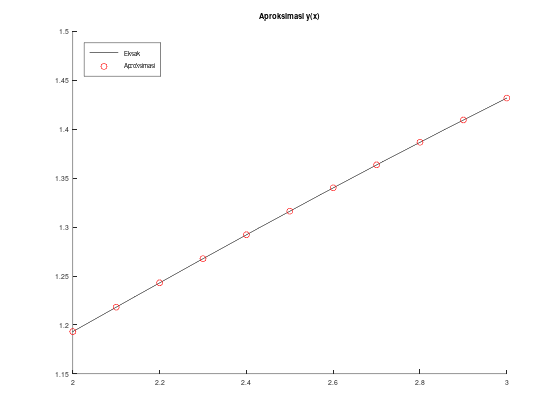

In [108]:
f=@(x,y,yp) yp+2*(y-log(x)).^3-1./x ; %fungsi f pada y=f(x,y,y')
f_y=@(x,y,yp) 6*(y-log(x)).^2; %turunan fungsi f terhadap y
f_yp=@(x,y,yp) 1; %turunan fungsi f terhadap yprime
a=2; %left boundary
b=3; %right boundary
alpha=0.5+log(2); %y(a)
beta=1/3+ log(3); %y(b)
n=9; %banyaknya partisi (pilih n=9 sehingga h=0.1)
TOL=10^(-4); %toleransi nilai (untuk kriteria stop)
maxiter=30; %masksimal itesrasi newton methodnya

%memanggil fungsi nonlinear_FDM_pseudocode
[x_grid, w_grid] = nonlinear_FDM_pseudocode(f,f_y,f_yp,a,b,n,alpha,beta,TOL,maxiter);
sln = @(x) 1./x + log(x); %sol analitik
y_eksak = sln(x_grid);

% menghitung error
err_w = abs(y_eksak - w_grid);

[x_grid, w_grid, y_eksak, err_w]

%membuat grafiknya
hold on;
fplot(sln, [a,b], 'k');
scatter(x_grid, w_grid, 'r');
title("Aproksimasi y(x)");
legend("Eksak", "Aproksimasi");
legend("location", "northwest");

Pilihan lain, kita bisa menggunakan fungsi yang menyusun matriks Jacobian lalu menyelesaikan SPLnya secara langsung:

Tabel aproksimasi, solusi y(x), dan error:
ans =

   2.000000000000000   1.193147180559945   1.193147180559945                   0
   2.100000000000000   1.218136665897076   1.218127820919853   0.000008844977223
   2.200000000000000   1.243017438585886   1.243002814909725   0.000014623676161
   2.300000000000000   1.267709758540398   1.267691731630756   0.000018026909642
   2.400000000000000   1.292154898557824   1.292135404020567   0.000019494537257
   2.500000000000000   1.316310046093640   1.316290731874155   0.000019314219485
   2.600000000000000   1.340144522402694   1.340126829642821   0.000017692759873
   2.700000000000000   1.363636945192896   1.363622143380654   0.000014801812242
   2.800000000000000   1.386773073873609   1.386762274324015   0.000010799549594
   2.900000000000000   1.409544153003318   1.409538323199325   0.000005829803994
   3.000000000000000   1.431945622001443   1.431945622001443                   0



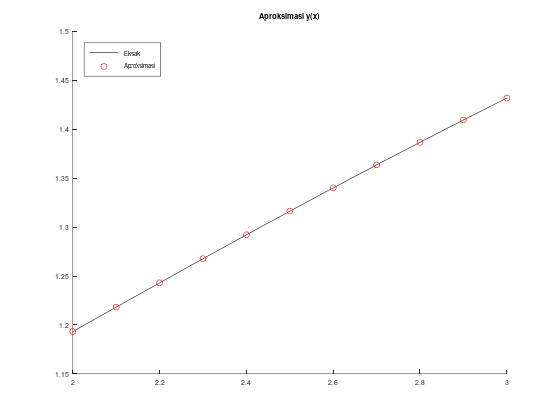

In [109]:
f = @(x,y,yp) yp + 2*(y-log(x)).^3 - 1./x ; %fungsi f pada y=f(x,y,y')
fy = @(x,y,yp) 6*(y-log(x)).^2; %turunan fungsi f terhadap y
fyp = @(x,y,yp) 1; %turunan fungsi f terhadap yprime
a = 2; %left boundary
b = 3; %right boundary
N = 9; %banyaknya partisi (pilih N=9 sehingga h=0.1)
alph = 0.5 + log(2); %y(a)
bet = 1/3 + log(3); %y(b)
tol = 10^(-4); %toleransi nilai (untuk kriteria stop)
M = 30; %masksimal itesrasi newton methodnya

[x_grid, w_grid] = nonlinear_fd_langsung(f, fy, fyp, a, b, N, alph, bet, tol, M);

% solusi eksak
sln = @(x) 1./x + log(x);
y_eksak = sln(x_grid);

% menghitung error
err_w = abs(y_eksak - w_grid);

% tampilkan tabel
format long;
disp("Tabel aproksimasi, solusi y(x), dan error:");
[x_grid, w_grid, y_eksak, err_w]
format;

hold on;
fplot(sln, [a, b], 'k');
scatter(x_grid, w_grid, 'r');
title("Aproksimasi y(x)");
legend("Eksak", "Aproksimasi");
legend("location", "northwest");

### Contoh 2

Selesaikan maslaah nilai batas berikut

$$y'' = \frac{1}{8} \left(32 + 2x^3 - yy'\right), \quad 1 \le x \le 3$$
$$y(1) = 17, \quad y(3) = \frac{43}{3}$$

dengan $h=0.1$, toleransi $10^{-8}$, dan maksimum iterasi $M=30$. Bandingkan hasilnya dengan solusi eksak

$$y(x) = x^2 + \frac{16}{x}$$

Hint:

$$y'' = f(x, y, y') = \frac{1}{8} \left(32 + 2x^3 - yy'\right)$$

$$f_{y} (x, y, y') = \frac{\partial f}{\partial y} (x, y, y') = -\frac{1}{8} y'$$

$$f_{y'} (x, y, y') = \frac{\partial f}{\partial y'} (x, y, y') = -\frac{1}{8} y$$

Tabel aproksimasi, solusi y(x), dan error:
ans =

 Columns 1 through 3:

   1.000000000000000e+00   1.700000000000000e+01   1.700000000000000e+01
   1.100000000000000e+00   1.575450253529389e+01   1.575545454545455e+01
   1.200000000000000e+00   1.477173965356983e+01   1.477333333333333e+01
   1.300000000000000e+00   1.399567743713438e+01   1.399769230769231e+01
   1.400000000000000e+00   1.338629656205142e+01   1.338857142857143e+01
   1.500000000000000e+00   1.291425241252499e+01   1.291666666666667e+01
   1.600000000000000e+00   1.255753822750665e+01   1.256000000000000e+01
   1.700000000000000e+00   1.229932628240154e+01   1.230176470588235e+01
   1.800000000000000e+00   1.212652886701783e+01   1.212888888888889e+01
   1.900000000000000e+00   1.202881380980783e+01   1.203105263157895e+01
   2.000000000000000e+00   1.199791542246045e+01   1.200000000000000e+01
   2.100000000000000e+00   1.202714237122990e+01   1.202904761904762e+01
   2.200000000000000e+00   1.211101980435058e+01   

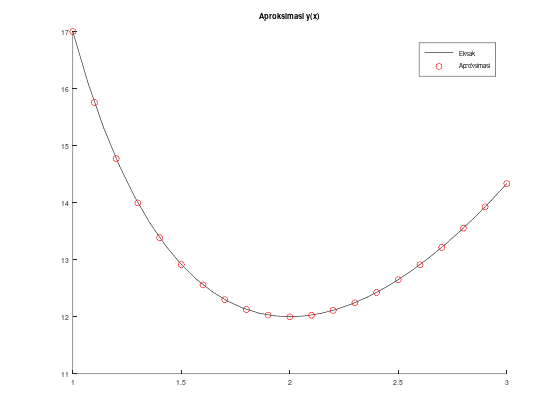

In [113]:
f = @(x, y, yp) ((1/8)*(32 + 2 * x.^3 - y .* yp));
fy = @(x, y, yp) (-yp/8);
fyp = @(x, y, yp) (-y/8);
a = 1;
b = 3;
h = 0.1;
N = (b - a)/h - 1;
alph = 17;
bet = 43/3;
tol = 10^(-8);
M = 30;

[x_grid, w_grid] = nonlinear_fd_langsung(f, fy, fyp, a, b, N, alph, bet, tol, M);

% solusi eksak
sln = @(x) ((x .^ 2) + ((16 ./ x)));
y_eksak = sln(x_grid);

% menghitung error
err_w = abs(y_eksak - w_grid);

% tampilkan tabel
format long;
disp("Tabel aproksimasi, solusi y(x), dan error:");
[x_grid, w_grid, y_eksak, err_w]
format;

hold on;
fplot(sln, [a, b], 'k');
scatter(x_grid, w_grid, 'r');
title("Aproksimasi y(x)");
legend("Eksak", "Aproksimasi");
legend('location', 'northeast');

## PDP Eliptik/Laplace/Poisson

### Bentuk umum, ide utama, penyederhanaan

### *Function file*

### Contoh soal

In [ ]:
db = @(x,y) 0;
ub = @(x,y) 200*x;
lb = @(x,y) 0;
rb = @(x,y) 200*y;
f = @(x,y) 0;
xb = 0;
xu = 0.5;
yb = 0;
yu = 0.5;
dx = 0.1;
dy = 0.1;
iterasi = 50;

[x, y, w] = metode_eliptik_iteratif(db, ub, lb, rb, f, xb, xu, yb, yu, dx, dy, iterasi);

mesh(x, y, w');

## PDP Hiperbolik / Persamaan Gelombang

### Bentuk umum, ide utama, penyederhanaan

### *Function file*

### Contoh soal